<!-- Notebook Header Start -->

<h1 align="center">Changes to Noxious Stimuli by means of Dorsal Root Ganglion Stimulation</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2025-04-26<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---


## 📊 Notebook Outline

* **Importing libraries & data**
* **Preprocess neurophysiology recordings for spike sorting**
* **Package preprocessed data for spike sorting using Kilosort4**
* **Run Kilosort to extract spike activity**
* **Calculate average firing rate of each cluster during noxious stimuli**
* **Compare the firing rates of clusters before and after noxious stimuli**

## 📚 References & Additional Resources

- [Kilosort4 docs](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface docs](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# ➡ Importing Libraries & Data
---

In [1]:
# standard imports
from pathlib import Path
import os
from kilosort import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# custom imports
from automations import RM1
from automations import plots
from automations import analysis_functions



### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

I am running my latest analysis, but with Charlie's probe to make sure that I am doing this right

In [2]:
PROBE_DIRECTORY = Path(r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32_max_murphy_probe.prb")

### filepath definitions

In [3]:
# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# in this case, the data is saved in a folder with multiple rats
DATA_DIRECTORY = Path(fr'D:\SynologyDrive\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  
# Create path if it doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

# NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# save data to the inbox; make sure that the folders: binary & figures exist

# select your path

# the following save directory has already been run, and it stores data that has been unaltered
SAVE_DIRECTORY = Path(fr"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.015 Multi_Rat_Linear_Mixed_Effects_max_probe")

# Create paths if they don't exist
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)

# run a multi-rat class

In [4]:
# all trials
rats = [RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, rat_id) for rat_id in ['DW322', 'DW323', 'DW327','DW361']]

# just the one I want for now. you need to pass it as a list, even if it's just one
# rats = [RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, rat_id) for rat_id in ['DW361']]

group = RM1.RatGroup(rats)
group.run_preprocessing(remove_drg_stim=True)  # preprocess all rats at once

Reading DRGS_10_240918_140034...
Error reading stream 2 for DRGS_10_240918_140034: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_11_240918_140803...
Error reading stream 2 for DRGS_11_240918_140803: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_12_240918_141655...
Error reading stream 2 for DRGS_12_240918_141655: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_1_240918_125448...
Error reading stream 2 for DRGS_1_240918_125448: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_2_240918_130024...
Error reading stream 2 for DRGS_2_240918_130024: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_3_240918_130835...
Error reading stream 2 for DRGS_3_240918_130835: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_4_240918_131552...
Error reading stream 2 for DRGS_4_240918_131552: stream_id 2 is not in ['0', '1', '3', '4']
Reading DRGS_5_240918_132233...
Error reading stream 2 for DRGS_5_240918_132233: stream_id 2 is not in ['0', '1', '3', '4']
Re

In [5]:
group.rats.keys()

dict_keys(['DW322', 'DW323', 'DW327', 'DW361'])

## run spikeinterface

20250411 update: I am using the bandpass filter (300 Hz - 3000 Hz) from Ting et al. 2024 and the notch filter (60Hz) from Wang et al. 2024

I am using 60 Hz instead of 50 Hz because Wang et al. 2024 was in China, and the supplied power is 50 Hz, and in the US it is 60 Hz

In [6]:
si_wrappers = group.create_spikeinterface_wrappers(SAVE_DIRECTORY)
for rat_id in si_wrappers.keys():
    # si_wrappers[rat_id].save_spinalcord_data_to_binary(bandpass_freq_min=300, bandpass_freq_max=3000, notch_freq=60)
    pass

Preparing SpikeInterface wrapper for rat DW322
Preparing SpikeInterface wrapper for rat DW323
Preparing SpikeInterface wrapper for rat DW327
Preparing SpikeInterface wrapper for rat DW361


## run kilosort & auto-analysis

In [7]:
ks_wrappers = group.create_kilosort_wrappers(SAVE_DIRECTORY, probe_directory=PROBE_DIRECTORY)
def my_custom_criteria(cluster_labels, st, clu, est_contam_rate, fs):   
    # Example criteria: Contamination rate < 15% and firing rate between 0.1 and 1000 Hz
    contam_good = est_contam_rate < 0.15
    fr_good = np.zeros(cluster_labels.size, dtype=bool)
    for i, c in enumerate(cluster_labels):
        spikes = st[clu == c]
        fr = spikes.size / ((spikes.max() - spikes.min()) / fs)
        if 0.1 <= fr <= 1000:
            fr_good[i] = True
    return np.logical_and(contam_good, fr_good)

Preparing Kilosort wrapper for DW322
Preparing Kilosort wrapper for DW323
Preparing Kilosort wrapper for DW327
Preparing Kilosort wrapper for DW361


In [8]:
for rat_id in ks_wrappers.keys():
    # ks_wrappers[rat_id].run_kilosort_trial_summary(new_settings="vf_settings_flex_probe",custom_criteria=my_custom_criteria)
    ks_wrappers[rat_id].extract_kilosort_outputs()

Kilosort outputs successfully loaded for trial: VF_1_240918_143256
Kilosort outputs successfully loaded for trial: VF_2_240918_143936
Kilosort outputs successfully loaded for trial: VF_3_240918_144658
Kilosort outputs successfully loaded for trial: VF_4_240918_145638
Kilosort outputs successfully loaded for trial: VF_5_240918_150137
Kilosort outputs successfully loaded for trial: VF_6_240918_150811
Kilosort outputs successfully loaded for trial: VF_7_240918_151516
Kilosort outputs successfully loaded for trial: VF_8_240918_152056
Kilosort outputs successfully loaded for trial: VF_9_240918_152753
Kilosort outputs successfully loaded for trial: VF_1_240911_164342
Kilosort outputs successfully loaded for trial: VF_2_240911_165039
Kilosort outputs successfully loaded for trial: VF_3_240911_165617
Kilosort outputs successfully loaded for trial: VF_4_240911_170446
Kilosort outputs successfully loaded for trial: VF_5_240911_171014
Kilosort outputs successfully loaded for trial: VF_6_240911_17

In [9]:
multi_analysis = analysis_functions.MultiRatVonFreyAnalysis(group, si_wrappers, ks_wrappers)
combined_results = multi_analysis.analyze_all_trials(
    excel_parent_folder=SAVE_DIRECTORY,
    subwindow_width=0.5,
    corr_threshold=0.01
)

# 🧮 Modular Kilosort Output Access and Visualization Examples

Below are examples of how to use the new modular methods for accessing and visualizing Kilosort outputs. Adjust the trial and cluster IDs as needed for your data.

### pick rat ID you want to look at

In [10]:
rat_id = "DW322"

### reload libraries

In [11]:
import importlib
import automations.RM1
importlib.reload(automations.plots)
importlib.reload(automations.analysis_functions)

<module 'automations.analysis_functions' from 'c:\\Users\\Karl\\Documents\\_Python\\CMU.49.003-Spike-Sorting-Kilosort\\automations\\analysis_functions.py'>

### Choose a sample trial and cluster

In [12]:
sample_trial = list(ks_wrappers[rat_id].kilosort_results.keys())[0]  # e.g., 'VF_1_240918_143256'
sample_trial

'VF_1_240918_143256'

In [13]:
sample_cluster = ks_wrappers[rat_id].get_clusters(sample_trial)[11]   # e.g., 0
sample_cluster

13

### --- Example: Visualization Using Kilosort Ouputs ---

#### 1. Get spike times for all clusters and for good clusters

In [14]:
# Get good unit labels
good_clusters = ks_wrappers[rat_id].get_good_clusters(sample_trial)

# Filter spike times and clusters for only good units
spike_times_all = ks_wrappers[rat_id].get_spike_times(sample_trial)
spike_times_good = spike_times_all[np.isin(ks_wrappers[rat_id].kilosort_results[sample_trial]['spike_clusters'], good_clusters)]
spike_times_cluster = ks_wrappers[rat_id].get_spike_times(sample_trial, cluster_id=sample_cluster) if sample_cluster in good_clusters else None
clusters = ks_wrappers[rat_id].kilosort_results[sample_trial]['spike_clusters']
clusters_good = clusters[np.isin(clusters, good_clusters)]
fs = ks_wrappers[rat_id].kilosort_results[sample_trial]['ops']['fs']

#### 2. Plot raster for good clusters / all clusters

good units

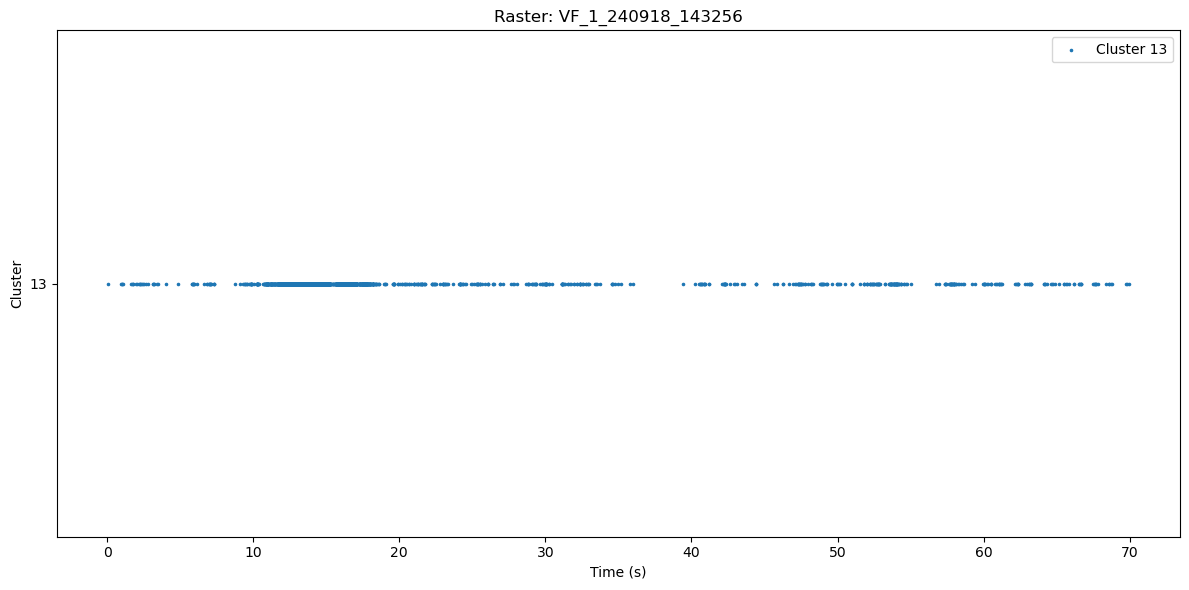

In [15]:
from automations.plots import plot_raster, plot_waveform
plot_raster(spike_times_good, clusters_good, fs=fs, title=f'Raster: {sample_trial}')

all units

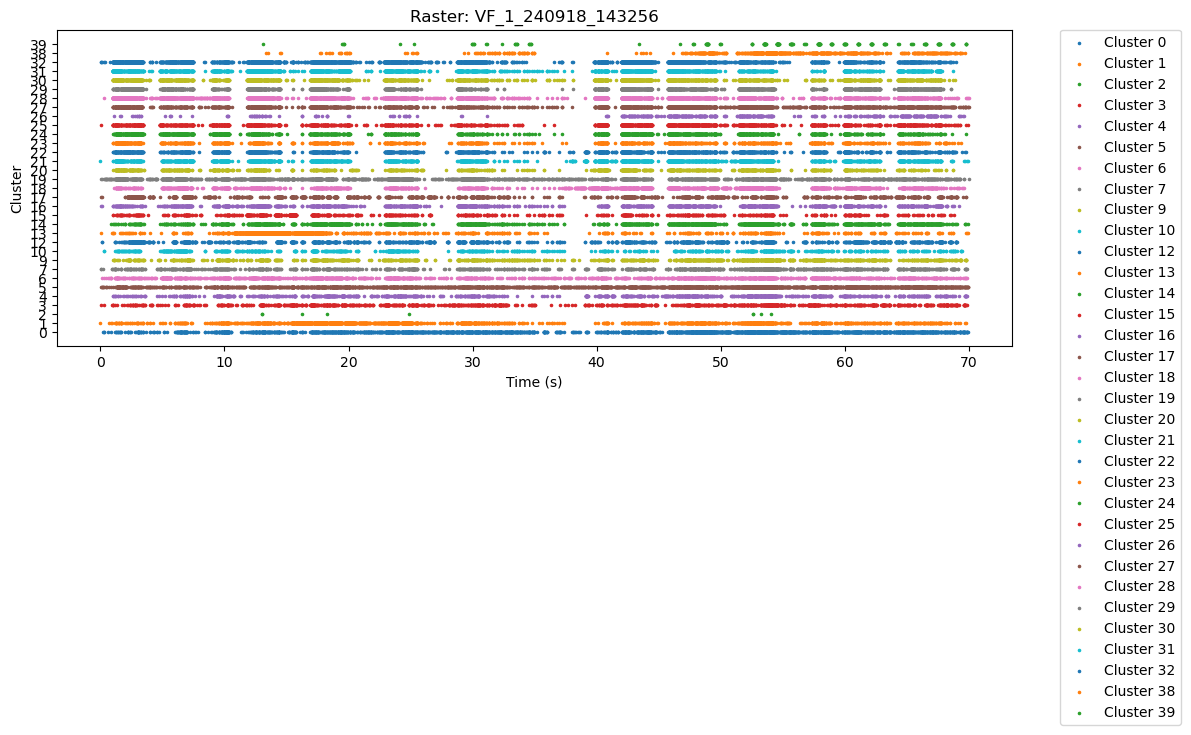

In [16]:
plot_raster(spike_times_all, clusters, fs=fs, title=f'Raster: {sample_trial}')

#### 3. Plot mean waveform for a good cluster

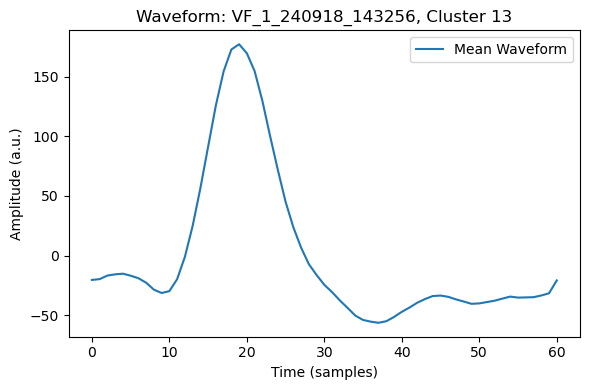

In [17]:
waveform = ks_wrappers[rat_id].get_waveform(sample_trial, sample_cluster)
plot_waveform(waveform, title=f'Waveform: {sample_trial}, Cluster {sample_cluster}')

#### 4. Compute firing rates for subwindows using the modular analysis function

In [18]:
# Example subwindow times (replace with your actual subwindow times)
subwindow_start_times = np.array([0, 1, 2])  # seconds
subwindow_end_times = np.array([1, 2, 3])    # seconds
spike_times_sec = ks_wrappers[rat_id].kilosort_results[sample_trial]['spike_times'] / fs
clusters_arr = ks_wrappers[rat_id].kilosort_results[sample_trial]['spike_clusters']
from automations.analysis_functions import VonFreyAnalysis
vfa = VonFreyAnalysis(group.rats[rat_id], si_wrappers[rat_id], ks_wrappers[rat_id])  # Use your actual instances
firing_rates_df = vfa.compute_unit_firing_rates_for_subwindows_modular(
    spike_times_sec, clusters_arr, subwindow_start_times, subwindow_end_times
)
print(firing_rates_df)

     0     1    2     3     4     5     6     7     9     10  ...    25   26  \
0   5.0   4.0  0.0   4.0   0.0  11.0   9.0   6.0   0.0   2.0  ...   1.0  0.0   
1  11.0  16.0  0.0   6.0  11.0  65.0  29.0  16.0   9.0  21.0  ...  69.0  3.0   
2  10.0  13.0  0.0  20.0  11.0  34.0  19.0  23.0  29.0  25.0  ...  67.0  5.0   

      27     28     29     30     31     32   38   39  
0    0.0    2.0    0.0    0.0    0.0    9.0  0.0  0.0  
1   98.0  147.0   96.0  108.0  160.0  139.0  0.0  0.0  
2  101.0  144.0  176.0   93.0   79.0  152.0  0.0  0.0  

[3 rows x 33 columns]


### --- Example: Modular Inverse-ISI and Correlation Calculation ---

#### 1. Extract spike and analog data for a sample trial

(deactivated so I can debug the code)

In [19]:
# rat_id = list(ks_wrappers.keys())[0]
# ksw = ks_wrappers[rat_id]
# sample_trial = list(ksw.kilosort_results.keys())[0]
# spike_times = ksw.kilosort_results[sample_trial]['spike_times']
# clusters = ksw.kilosort_results[sample_trial]['spike_clusters']
# fs = ksw.kilosort_results[sample_trial]['ops']['fs']
# recording = group.rats[rat_id].analog_data[sample_trial]
# von_frey_data = recording.get_traces(channel_ids=['ANALOG-IN-2'], return_scaled=True).flatten()

# vfa = analysis_functions.VonFreyAnalysis(group.rats[rat_id], si_wrappers[rat_id], ks_wrappers[rat_id])
# correlations, inv_isi_traces = vfa.compute_inv_isi_correlation_modular(
#     spike_times, clusters, fs, von_frey_data, window_size=15000
# )
# print('Correlations:', correlations)
# sample_cluster = list(correlations.keys())[11]
# vfa.plot_inv_isi_vs_von_frey(von_frey_data, inv_isi_traces, correlations, sample_trial, sample_cluster)

# 📈 Von Frey Analysis plot

In [20]:
# Prepare a dictionary of good clusters for each trial for each rat
good_clusters_by_rat_and_trial = {}

for rat_id, ks_wrapper in ks_wrappers.items():
    good_clusters_by_trial = {}
    for trial_name in ks_wrapper.kilosort_results.keys():
        good_clusters = ks_wrapper.get_good_clusters_from_group(trial_name)
        good_clusters_by_trial[trial_name] = good_clusters
    good_clusters_by_rat_and_trial[rat_id] = good_clusters_by_trial

# Now, when running the analysis, you need to pass this information down.
# If your analysis pipeline (e.g., analyze_all_trials) does not currently accept this,
# you may need to modify it to accept and use this dictionary.

# Example: If you want to analyze only one rat:
rat_id = list(ks_wrappers.keys())[0]
good_clusters_by_trial = good_clusters_by_rat_and_trial[rat_id]

# If you want to analyze all rats, you may need to modify your pipeline to accept this structure.
# For now, let's show how to use it for a single rat and trial:

trial_name = list(ks_wrappers[rat_id].kilosort_results.keys())[0]
good_clusters = good_clusters_by_trial[trial_name]
print(f"Good clusters for {rat_id}, {trial_name}: {good_clusters}")

# If you want to filter spike/cluster data in your analysis, you can do:
spike_times = ks_wrappers[rat_id].get_spike_times(trial_name)
clusters = ks_wrappers[rat_id].kilosort_results[trial_name]['spike_clusters']
good_mask = np.isin(clusters, good_clusters)
filtered_spike_times = spike_times[good_mask]
filtered_clusters = clusters[good_mask]

Good clusters for DW322, VF_1_240918_143256: [38, 39]


In [21]:
good_clusters = [int(c) for c in good_clusters]
clusters = ks_wrappers[rat_id].kilosort_results[trial_name]['spike_clusters']
print("All unique clusters in spike_clusters:", np.unique(clusters))
print("Good clusters:", good_clusters)
for gc in good_clusters:
    count = np.sum(clusters == gc)
    print(f"Spikes assigned to cluster {gc}: {count}")

All unique clusters in spike_clusters: [ 0  1  2  3  4  5  6  7  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 38 39]
Good clusters: [38, 39]
Spikes assigned to cluster 38: 846
Spikes assigned to cluster 39: 187


### multi-animal von frey analysis

In [22]:

multi_analysis = analysis_functions.MultiRatVonFreyAnalysis(group, si_wrappers, ks_wrappers)
combined_results = multi_analysis.analyze_all_trials(
    excel_parent_folder=SAVE_DIRECTORY,
    subwindow_width=0.5,
    corr_threshold=0.0001
)

If you want to provide your own custom good clusters:
You can build a dictionary like this (optional):

' # Example: custom good clusters for each rat and trial
custom_good_clusters = {
    'DW322': {'trial1': [1,2,3], 'trial2': [4,5]},
    'DW323': {'trial1': [7,8]}
}
combined_results = multi_analysis.analyze_all_trials(
    excel_parent_folder=SAVE_DIRECTORY,
    subwindow_width=0.5,
    corr_threshold=0.01,
    good_clusters_by_trial=custom_good_clusters
)


### combining the experiment notes for individual animals, for combined plots and linear mixed effects modeling.

In [23]:
def make_unique_cols(df):
    new_cols = []
    seen = {}
    for col in df.columns:
        if col in seen:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
        else:
            seen[col] = 0
            new_cols.append(col)
    df.columns = new_cols
    return df

dfs = []
for rat_id, rat in group.rats.items():
    df = make_unique_cols(rat.qst_trial_notes.copy())
    df['Rat ID'] = rat_id
    df["Trial Number"] = rat_id + "_" + df["Trial Number"].astype(str)
    dfs.append(df)

combined_qst_notes = pd.concat(dfs, ignore_index=True)

# Sort keys based on the numeric part after the second underscore (i.e., the zero-padded trial number)
sorted_keys = sorted(
    combined_results.keys(),
    key=lambda x: int(x.split('_')[2])
)

combined_qst_notes['Trial_ID'] = sorted_keys

# After concatenating your DataFrames into combined_qst_notes:
combined_qst_notes['Trial_ID'] = list(combined_results.keys())
combined_qst_notes

,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN,Rat ID,nan_1,Trial_ID
0,DW322_1,VF,51,300,5,180,vf,NaN,30,accidentally named DRGS_13,DW322,NaN,DW322_VF_1_240918_143256
1,DW322_2,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_2_240918_143936
2,DW322_3,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_3_240918_144658
3,DW322_4,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_4_240918_145638
4,DW322_5,VF,51,300,5,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_5_240918_150137
5,DW322_6,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_6_240918_150811
6,DW322_7,VF,51,300,5,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_7_240918_151516
7,DW322_8,VF,51,300,100,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_8_240918_152056
8,DW322_9,VF,51,300,20,180,vf,NaN,30,NaN,DW322,NaN,DW322_VF_9_240918_152753
9,DW323_1,VF,70,300,5,180,vf,NaN,30,pos 1,DW323,pad just prximal from toe,DW323_VF_1_240911_164342


In [24]:
dw322_trials = ["VF_1_240918_143256","VF_2_240918_143936","VF_3_240918_144658","VF_4_240918_145638","VF_5_240918_150137","VF_6_240918_150811",
                "VF_7_240918_151516","VF_8_240918_152056","VF_9_240918_152753"]

dw323_trials = ["VF_1_240911_164342","VF_2_240911_165039","VF_3_240911_165617","VF_4_240911_170446","VF_5_240911_171014","VF_6_240911_171505"]

dw327_trials = ["VF_01_241125_153746","VF_02_241125_154307","VF_03_241125_154841","VF_04_241125_155417","VF_05_241125_155941","VF_06_241125_160515",
                "VF_07_241125_161126","VF_08_241125_161626","VF_09_241125_162141","VF_10_241125_162725"]

dw361_trials = ["VF_1_250422_124925","VF_2_250422_125146","VF_3_250422_125632","VF_4_250422_130213","VF_5_250422_130729","VF_6_250422_131240",
                "VF_7_250422_131739","VF_8_250422_132231","VF_9_250422_132717","VF_10_250422_133218","VF_11_250422_133722","VF_12_250422_134214",
                "VF_13_250422_134725","VF_14_250422_154410","VF_14_250422_154410","VF_15_250422_154935","VF_16_250422_155509"]

### generate sanity plots for each trial 

#### DW322

In [25]:
# ks_wrappers["DW322"].plot_trial_results(dw322_trials)

#### DW323

In [26]:
# ks_wrappers["DW323"].plot_trial_results(dw323_trials)

#### DW327

In [27]:
# ks_wrappers["DW327"].plot_trial_results(dw327_trials)

#### DW361

In [28]:
# ks_wrappers["DW361"].plot_trial_results(dw361_trials)

##### NOTE:

seeing repeating units is not a sign that there is an issue: these plots a pick random units, (40) times, to show how spikes are captured on the probe. 

the fewer the number of good or mua units, the more likely there will be repeated units.

### plot characteristic waveform for each neuron

#### DW322

In [29]:
# ks_wrappers["DW322"].plot_cluster_waveforms(dw322_trials)

#### DW323

In [30]:
# ks_wrappers["DW323"].plot_cluster_waveforms(dw323_trials)

#### DW327

In [31]:
# ks_wrappers["DW327"].plot_cluster_waveforms(dw327_trials)

#### DW361

In [32]:
# ks_wrappers["DW361"].plot_cluster_waveforms(dw361_trials)

### combined VF plot

Correlation for cluster Unnamed: 0 not found in DW322_VF_1_240918_143256. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_1_240918_143256. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_2_240918_143936. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_2_240918_143936. Skipping...
No clusters in DW322_VF_2_240918_143936 meet corr_threshold=0.25. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_3_240918_144658. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_3_240918_144658. Skipping...
No clusters in DW322_VF_3_240918_144658 meet corr_threshold=0.25. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_4_240918_145638. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_4_240918_145638. Skipping...
No clusters in DW322_VF_4_240918_145638 meet corr_threshold=0.25. Skipping...
Correlation for cluster Unnamed: 0 not found in DW322_VF_5_240918_150137. Skip

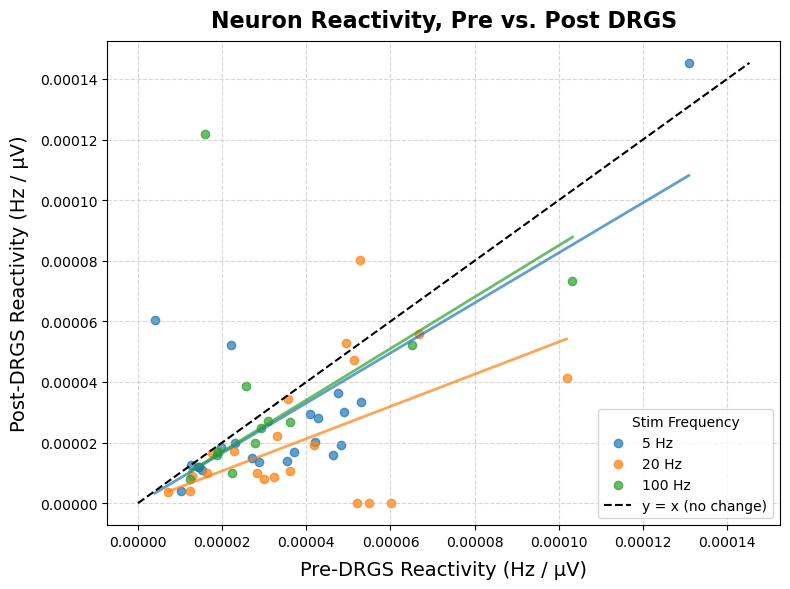

In [33]:
plots.vf_all_trials_combined_plot(combined_results, combined_qst_notes,corr_threshold=0.25)

###

# ↘️↙️Combine and Flatten Raw Data

### rev2

In [34]:
def flatten_and_filter_by_corr(combined_results,
                               combined_qst_notes,
                               corr_threshold=0.01):
    """
    For each trial in combined_results:
      • extract per-neuron correlation (last two rows of firing_df)
      • keep only clusters whose |corr| >= corr_threshold
      • melt firing rates, tag with timepoint index
      • tag voltage with the same timepoint index
      • merge one-to-one on timepoint
      • attach trial metadata from combined_qst_notes
    Returns a single concatenated DataFrame.
    """
    # build lookups from your QST notes
    meta = combined_qst_notes.set_index('Trial_ID')
    records = []

    for trial_id, res in combined_results.items():
        if trial_id not in meta.index:
            continue
        # pull trial metadata
        freq_hz    = meta.at[trial_id, 'Freq. (Hz)']
        amp_val    = meta.at[trial_id, 'amp']
        pw_us      = meta.at[trial_id, 'PW (us)']
        rat_id     = meta.at[trial_id, 'Rat ID']

        vdf = res.get('voltage_df')
        fdf = res.get('firing_df')
        if vdf is None or fdf is None or len(fdf) < 2:
            continue

        # 1) extract correlations (second-to-last row), build corr_dict
        corr_row = fdf.iloc[-2].to_dict()
        corr_dict = {int(k): float(v)
                     for k, v in corr_row.items()
                     if isinstance(k, (str, int)) and str(k).isdigit()}

        # 2) pick only clusters passing threshold
        valid_clusters = {c for c, r in corr_dict.items()
                          if abs(r) >= corr_threshold}
        if not valid_clusters:
            continue

        # 3) clean off the two bottom rows, tag each row with its original index
        firing_clean = fdf.iloc[:-2].copy()
        firing_clean['timepoint'] = firing_clean.index

        voltage_clean = vdf.copy()
        voltage_clean['timepoint'] = voltage_clean.index

        # 4) melt firing → long, convert cluster → numeric, filter by valid_clusters
        fm = (
            firing_clean
            .melt(
                id_vars=['timepoint', 'group'],
                var_name='cluster',
                value_name='firing_rate'
            )
            .assign(cluster=lambda df: pd.to_numeric(df['cluster'], errors='coerce'))
            .query("cluster in @valid_clusters")
        )

        # 5) one-to-one merge on timepoint (group could be included if you want)
        merged = (
            fm
            .merge(
                voltage_clean[['timepoint', 'avg_voltage', 'group']],
                on=['timepoint', 'group'],
                how='left'
            )
        )

        # 6) attach correlation & trial metadata
        merged['correlation']              = merged['cluster'].map(corr_dict)
        merged['Trial_ID']                 = trial_id
        merged['Frequency_Hz']             = freq_hz
        merged['Amplitude']                = amp_val
        merged['Pulse_Width(us)']          = pw_us
        merged['Rat_ID']                   = rat_id
        merged['firing_rate_vs_stim(uV^-1)'] = merged['Frequency_Hz'] / merged['avg_voltage']

        records.append(merged)

    # concatenate all trials
    if not records:
        return pd.DataFrame()

    final = pd.concat(records, ignore_index=True)
    return final


lmem = flatten_and_filter_by_corr(combined_results,
                                  combined_qst_notes,
                                  corr_threshold=0.01)
lmem.to_csv(SAVE_DIRECTORY / "flattened_data_rev2.csv", index=False)
lmem.iloc[1:50]

,timepoint,group,cluster,firing_rate,avg_voltage,correlation,Trial_ID,Frequency_Hz,Amplitude,Pulse_Width(us),Rat_ID,firing_rate_vs_stim(uV^-1)
1,1,pre-stim,38.0,0.0,2.268816e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000022
2,2,pre-stim,38.0,0.0,2.435388e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000021
3,3,pre-stim,38.0,0.0,2.261589e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000022
4,4,pre-stim,38.0,0.0,2.519395e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000020
5,5,pre-stim,38.0,0.0,3.783198e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000013
6,6,pre-stim,38.0,0.0,5.498015e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000009
7,7,pre-stim,38.0,0.0,6.244416e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000008
8,8,pre-stim,38.0,0.0,5.190457e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000010
9,9,pre-stim,38.0,0.0,3.837293e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000013
10,10,pre-stim,38.0,0.0,6.848429e+05,0.367087,DW322_VF_1_240918_143256,5,51,300,DW322,0.000007


### getting a better look at the force distribution

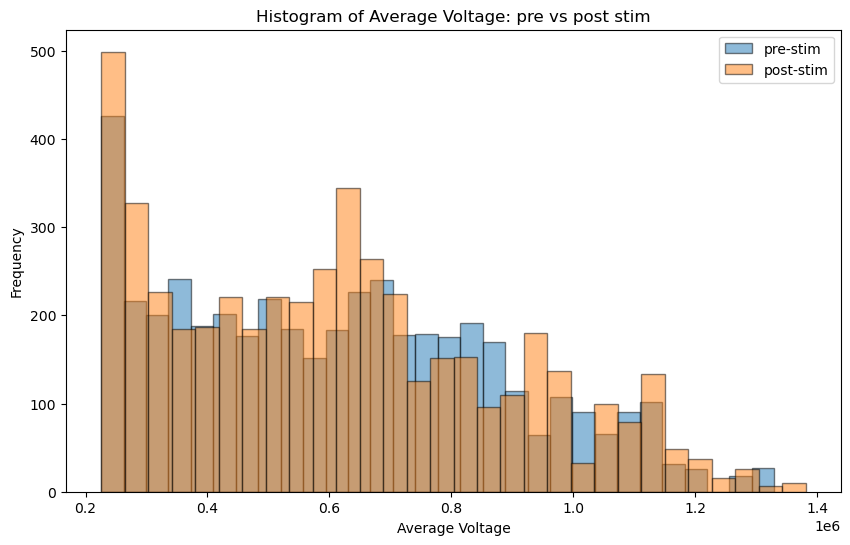

C:\Users\Karl\AppData\Local\Temp\ipykernel_40048\3856836436.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['pre-stim', 'post-stim'])


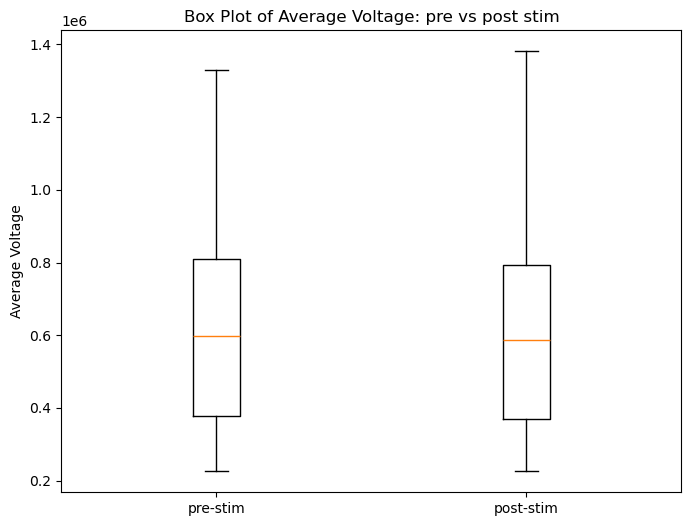

In [35]:

# histogram

pre_data = lmem[lmem['group'] == 'pre-stim']['avg_voltage']
post_data = lmem[lmem['group'] == 'post-stim']['avg_voltage']

plt.figure(figsize=(10, 6))
plt.hist(pre_data, bins=30, alpha=0.5, label='pre-stim', edgecolor='black')
plt.hist(post_data, bins=30, alpha=0.5, label='post-stim', edgecolor='black')
plt.title('Histogram of Average Voltage: pre vs post stim')
plt.xlabel('Average Voltage')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# boxplot

plt.figure(figsize=(8, 6))
data_to_plot = [
    pre_data,
    post_data
]
plt.boxplot(data_to_plot, labels=['pre-stim', 'post-stim'])
plt.title('Box Plot of Average Voltage: pre vs post stim')
plt.ylabel('Average Voltage')
plt.show()


it honestly doesn't look too different - what could the issue be??

### grouping the dataset by "bins" of stimulus

In [36]:

# 1. Define bin edges: we go from 0 to slightly above the max value in steps of 50,000.
max_val = lmem['avg_voltage'].max()
bin_edges = np.arange(0, max_val + 10000, 10000)

# 2. Create labels that match the upper bound of each bin.
#    For instance, bin [0, 50000] gets the label "50000", bin (50000, 100000] gets "100000", etc.
labels = [str(int(x)) for x in bin_edges[1:]]

# 3. Use pd.cut to discretize avg_voltage. 
#    include_lowest=True ensures that 0 goes into the first bin. 
#    With right=True (the default), intervals are (a, b], so 50,000 falls in the first bin.
lmem['voltage_bin'] = pd.cut(lmem['avg_voltage'], 
                           bins=bin_edges, 
                           labels=labels, 
                           include_lowest=True,
                           right=True)

# Now each row has a "voltage_bin" indicating its bin.


# see bin counts
bin_counts = lmem['voltage_bin'].value_counts().sort_index()
print("Number of entries in each bin (uV):")
print(bin_counts)


Number of entries in each bin (uV):
voltage_bin
10000      0
20000      0
30000      0
40000      0
50000      0
          ..
1350000    5
1360000    0
1370000    0
1380000    0
1390000    5
Name: count, Length: 139, dtype: int64


In [37]:
# Group by 'cluster' and 'voltage_bin' then calc mean firing rate
avg_firing_rate = lmem.groupby(['Rat_ID',"Trial_ID",'cluster', 'voltage_bin', "Frequency_Hz", 'group'])['firing_rate'].mean().reset_index().dropna()
# avg_firing_rate["firing_rate"] = avg_firing_rate["firing_rate"].astype(float) # I think it already does this, no need to specify againa
avg_firing_rate.to_csv(SAVE_DIRECTORY / "grouped_stimulus.csv")
avg_firing_rate

C:\Users\Karl\AppData\Local\Temp\ipykernel_40048\16533545.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_firing_rate = lmem.groupby(['Rat_ID',"Trial_ID",'cluster', 'voltage_bin', "Frequency_Hz", 'group'])['firing_rate'].mean().reset_index().dropna()


,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,group,firing_rate
28488,DW322,DW322_VF_1_240918_143256,38.0,230000,5,post-stim,0.0
28489,DW322,DW322_VF_1_240918_143256,38.0,230000,5,pre-stim,0.0
28495,DW322,DW322_VF_1_240918_143256,38.0,240000,5,pre-stim,0.0
28500,DW322,DW322_VF_1_240918_143256,38.0,250000,5,post-stim,43.290043
28501,DW322,DW322_VF_1_240918_143256,38.0,250000,5,pre-stim,0.0
...,...,...,...,...,...,...,...
6929519,DW361,DW361_VF_9_250422_132717,61.0,1080000,100,pre-stim,62.0
6929524,DW361,DW361_VF_9_250422_132717,61.0,1090000,100,post-stim,88.0
6929543,DW361,DW361_VF_9_250422_132717,61.0,1120000,100,pre-stim,72.0
6929561,DW361,DW361_VF_9_250422_132717,61.0,1150000,100,pre-stim,56.0


IMPORTANT: this code need to drop zero entries, because you can't calculate % change with zero.

In [38]:
# Pivot the data so that pre-stim and post-stim firing rates become separate columns.
pre_post_pivot = avg_firing_rate.pivot_table(index=['Rat_ID', 'Trial_ID', 'cluster', 'voltage_bin', 'Frequency_Hz'],
                          columns='group',
                          values='firing_rate').reset_index()


# Remove rows where pre-stim is zero to avoid division by zero
pre_post_pivot = pre_post_pivot[pre_post_pivot['pre-stim'] != 0]


# Drop rows that do not have both pre-stim and post-stim values
pre_post_pivot = pre_post_pivot.dropna(subset=['pre-stim', 'post-stim'])

# Calc percent change, pre to post
pre_post_pivot['percent_change'] = ((pre_post_pivot['post-stim'] - pre_post_pivot['pre-stim']) / pre_post_pivot['pre-stim']) * 100

pre_post_pivot.to_csv(SAVE_DIRECTORY / "percent_change.csv")

pre_post_pivot


C:\Users\Karl\AppData\Local\Temp\ipykernel_40048\397580726.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pre_post_pivot = avg_firing_rate.pivot_table(index=['Rat_ID', 'Trial_ID', 'cluster', 'voltage_bin', 'Frequency_Hz'],


group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
24,DW322,DW322_VF_1_240918_143256,38.0,580000,5,30.0,6.0,400.0
25,DW322,DW322_VF_1_240918_143256,38.0,590000,5,10.0,3.0,233.333333
26,DW322,DW322_VF_1_240918_143256,38.0,610000,5,17.0,12.0,41.666667
28,DW322,DW322_VF_1_240918_143256,38.0,640000,5,26.0,10.0,160.0
38,DW322,DW322_VF_1_240918_143256,38.0,910000,5,70.0,2.0,3400.0
...,...,...,...,...,...,...,...,...
6027,DW361,DW361_VF_9_250422_132717,61.0,920000,100,16.0,58.0,-72.413793
6042,DW361,DW361_VF_9_250422_132717,61.0,720000,100,96.0,39.0,146.153846
6043,DW361,DW361_VF_9_250422_132717,61.0,760000,100,98.230295,56.0,75.411242
6044,DW361,DW361_VF_9_250422_132717,61.0,800000,100,100.0,22.0,354.545455


### converting the pivoted data to numeric

In [39]:
## voltage bin
# convert category → string → float (invalid entries become NaN)
pre_post_pivot["voltage_bin"] = pd.to_numeric(
    pre_post_pivot["voltage_bin"].astype(str), errors="coerce"
)

## pre-post stim
# turn everything numeric, coerce errors → NaN
for col in ["pre-stim", "post-stim"]:
    pre_post_pivot[col] = pd.to_numeric(pre_post_pivot[col], errors="coerce")

# drop rows that failed conversion or have zero pre‑stim
pre_post_pivot = pre_post_pivot.dropna(subset=["pre-stim", "post-stim"])
pre_post_pivot = pre_post_pivot[pre_post_pivot["pre-stim"] != 0]

## percent change
# recompute percent_change as float
pre_post_pivot["percent_change"] = (
    (pre_post_pivot["post-stim"] - pre_post_pivot["pre-stim"])
    / pre_post_pivot["pre-stim"]
) * 100

In [40]:
print(pre_post_pivot.dtypes.loc[["voltage_bin", "pre-stim",
                                 "post-stim", "percent_change"]])

group
voltage_bin         int64
pre-stim          float64
post-stim         float64
percent_change    float64
dtype: object


# 📊 % Change in Firing Rates, Grouped by Force (force-matched plots)
---

## Idea:
* The goal here is to create a plot similar to what I already have. But what I will do is plot the percent change in firing rate, for each neuron, along a batch of stimulation rates. so essentially, break up the voltage thresholds into a batch of voltage ranges, then group the firing rates in those batches, then plot the difference.

## Steps
1) Break up the voltages into batches of 100,000uV (there should be 4-8 groups within this range)
2) For each neuron, calculate the percent change in firing rate for each neuron, pre & post stimulation
3) plot the percent change on the y axis. do this for every neuron in the group. 
4) plot the percent change for each neuron to the color representing it's DRG stimulation frequency (5Hz, 20Hz, 100Hz)
5) draw a trendline for the percent change for each neuron (make the colors very similar to what I was using for the previous plot)

the percent change is given by:

$\%\ Change, Firing\ Rate = \frac{((Post-Stimulation\ Firing\ Rate))-(Pre-Stimulation\ Firing\ Rate)}{Pre-Stimulation\ Firing\ Rate}$

---

In [41]:
pre_post_pivot.sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
1562,DW327,DW327_VF_10_241125_162725,16.0,240000,5,72.0,2.000000,3500.000000
38,DW322,DW322_VF_1_240918_143256,38.0,910000,5,70.0,2.000000,3400.000000
1364,DW327,DW327_VF_07_241125_161126,7.0,310000,5,22.0,0.666667,3200.000000
5113,DW361,DW361_VF_5_250422_130729,75.0,540000,20,122.0,4.302309,2735.686667
899,DW327,DW327_VF_01_241125_153746,22.0,320000,5,27.0,1.000000,2600.000000
...,...,...,...,...,...,...,...,...
1912,DW361,DW361_VF_10_250422_133218,41.0,670000,5,0.0,6.000000,-100.000000
4535,DW361,DW361_VF_4_250422_130213,44.0,240000,5,0.0,23.112481,-100.000000
1911,DW361,DW361_VF_10_250422_133218,41.0,650000,5,0.0,29.000000,-100.000000
1910,DW361,DW361_VF_10_250422_133218,41.0,460000,5,0.0,14.000000,-100.000000


### method

In [42]:
def plot_percent_change(
    df: pd.DataFrame,
    voltage_bin_col: str = "voltage_bin",
    pre_col: str = "pre-stim",
    post_col: str = "post-stim",
    freq_col: str = "Frequency_Hz",
    percent_col: str = "percent_change",
    cluster_col: str = "cluster",
    add_trendlines: bool = True,
    cmap_name: str = "tab10",
):
    """
    Scatter‑plot percent change in firing rate versus voltage bin midpoint.

    Parameters
    ----------
    df : pandas.DataFrame
        Combined dataframe across all rats and trials.
    voltage_bin_col, pre_col, post_col, freq_col, percent_col, cluster_col : str
        Column names inside `df`.
    add_trendlines : bool
        Draw a linear trendline per frequency group when True.
    cmap_name : str
        Matplotlib colormap for assigning colors to frequency groups.
    """

    # --- Basic column check ---------------------------------------------------
    needed = {voltage_bin_col, pre_col, post_col, freq_col, cluster_col}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Dataframe missing columns: {missing}")
    

    # --- force voltage_bin to numeric even if categorical or object ---
    df = df.copy()
    df[voltage_bin_col] = pd.to_numeric(df[voltage_bin_col].astype(str), errors="coerce")
    df = df.dropna(subset=[voltage_bin_col])        # remove rows that failed coercion

    # --- Compute percent_change if absent ------------------------------------
    if percent_col not in df.columns:
        # avoid divide‑by‑zero and NaNs
        clean = df.dropna(subset=[pre_col, post_col]).copy()
        clean = clean[clean[pre_col] != 0]
        df[percent_col] = ((clean[post_col] - clean[pre_col]) / clean[pre_col]) * 100

    # --- Remove any rows still lacking valid percent_change ------------------
    plot_df = df.dropna(subset=[percent_col, voltage_bin_col, freq_col])

    if plot_df.empty:
        print("No data available after cleaning.")
        return

    # --- Color mapping -------------------------------------------------------
    freqs = np.sort(plot_df[freq_col].unique())
    cmap = plt.get_cmap(cmap_name)
    color_map = {f: cmap(i % cmap.N) for i, f in enumerate(freqs)}

    # --- Plot ----------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    for f in freqs:
        subset = plot_df[plot_df[freq_col] == f]
        x = subset[voltage_bin_col].values
        y = subset[percent_col].values

        ax.scatter(x, y, color=color_map[f], alpha=0.7, label=f"{f} Hz")

        # trendline only if at least two distinct x values
        if add_trendlines and np.unique(x).size > 1:
            slope, intercept = np.polyfit(x, y, 1)
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = slope * x_line + intercept
            ax.plot(x_line, y_line, color=color_map[f], linewidth=2, alpha=0.8)

    # --- Decorations ---------------------------------------------------------
    ax.axhline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel("Voltage Bin Midpoint (µV)")
    ax.set_ylabel("Percent Change in Firing Rate (%)")
    ax.set_title("Percent Change in Firing Rate by Voltage Bin")
    ax.legend(title="DRG Stimulation Frequency")
    plt.tight_layout()
    plt.show()

### all data, all rats

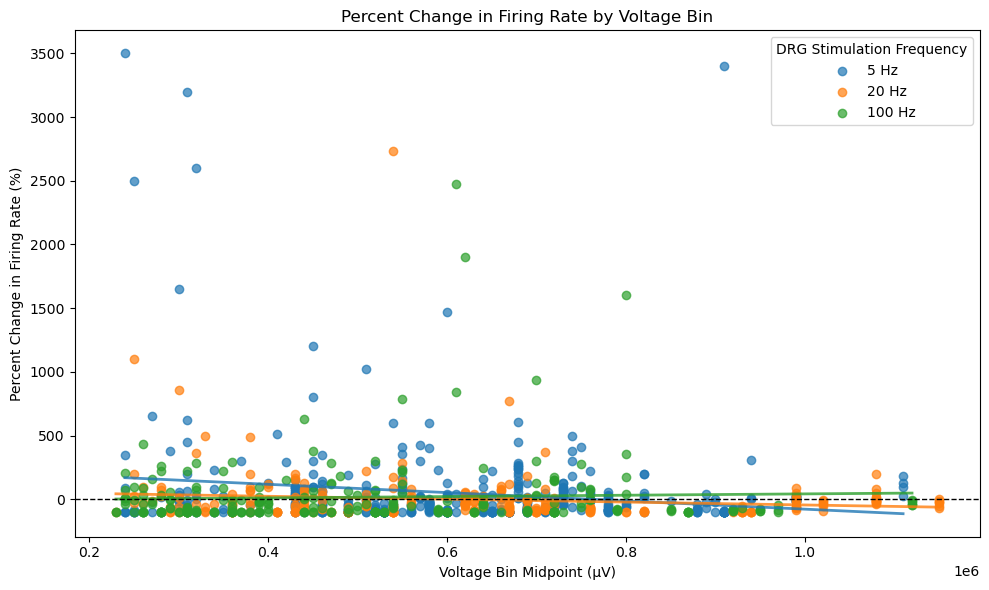

In [43]:
plot_percent_change(pre_post_pivot)

### DW323

In [44]:
pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW323"].sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
728,DW323,DW323_VF_1_240911_164342,1.0,310000,5,21.691974,3.000000,623.065799
739,DW323,DW323_VF_1_240911_164342,1.0,540000,5,14.000000,2.000000,600.000000
729,DW323,DW323_VF_1_240911_164342,1.0,370000,5,24.000000,6.000000,300.000000
733,DW323,DW323_VF_1_240911_164342,1.0,420000,5,24.747518,6.309967,292.197288
761,DW323,DW323_VF_3_240911_165617,37.0,260000,100,4.000000,6.000000,-33.333333
785,DW323,DW323_VF_3_240911_165617,37.0,510000,100,4.000000,6.000000,-33.333333
782,DW323,DW323_VF_3_240911_165617,37.0,360000,100,3.333333,6.492101,-48.655556
741,DW323,DW323_VF_1_240911_164342,1.0,570000,5,2.000000,4.000000,-50.000000
789,DW323,DW323_VF_3_240911_165617,37.0,460000,100,3.000000,10.000000,-70.000000
846,DW323,DW323_VF_4_240911_170446,17.0,300000,100,0.000000,2.000000,-100.000000


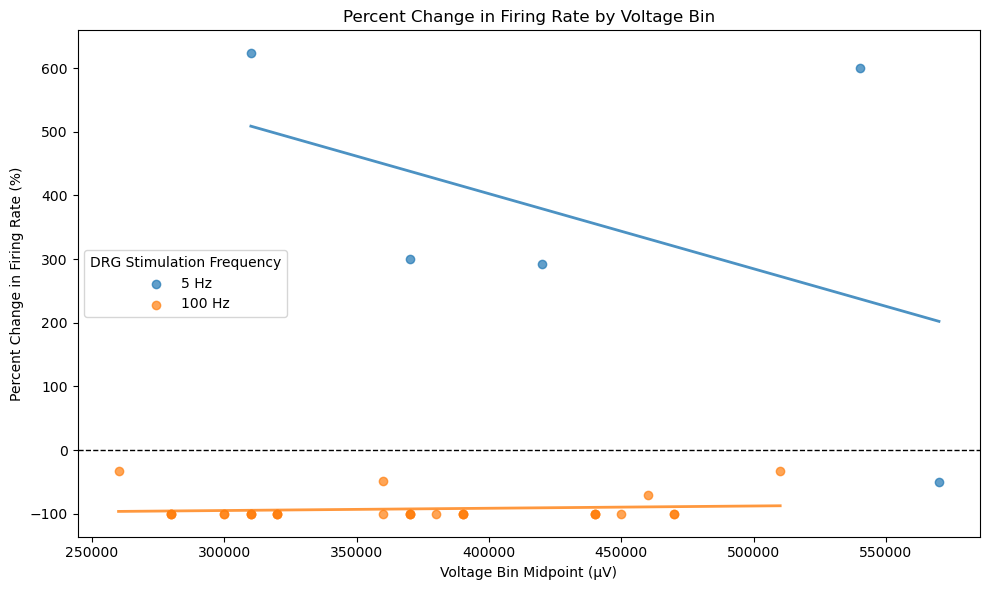

In [45]:
plot_percent_change(pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW323"])

### DW327

In [46]:
pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW327"].sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
1562,DW327,DW327_VF_10_241125_162725,16.0,240000,5,72.000000,2.000000,3500.000000
1364,DW327,DW327_VF_07_241125_161126,7.0,310000,5,22.000000,0.666667,3200.000000
899,DW327,DW327_VF_01_241125_153746,22.0,320000,5,27.000000,1.000000,2600.000000
1360,DW327,DW327_VF_07_241125_161126,7.0,250000,5,25.974026,1.000000,2497.402597
1496,DW327,DW327_VF_09_241125_162141,18.0,610000,100,60.000000,2.329916,2475.200000
...,...,...,...,...,...,...,...,...
1140,DW327,DW327_VF_04_241125_155417,11.0,310000,5,0.000000,38.353080,-100.000000
1137,DW327,DW327_VF_04_241125_155417,11.0,250000,5,0.000000,28.000000,-100.000000
1119,DW327,DW327_VF_04_241125_155417,4.0,320000,5,0.000000,3.054935,-100.000000
1115,DW327,DW327_VF_04_241125_155417,4.0,250000,5,0.000000,46.000000,-100.000000


In [47]:
pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW327"].sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
1562,DW327,DW327_VF_10_241125_162725,16.0,240000,5,72.000000,2.000000,3500.000000
1364,DW327,DW327_VF_07_241125_161126,7.0,310000,5,22.000000,0.666667,3200.000000
899,DW327,DW327_VF_01_241125_153746,22.0,320000,5,27.000000,1.000000,2600.000000
1360,DW327,DW327_VF_07_241125_161126,7.0,250000,5,25.974026,1.000000,2497.402597
1496,DW327,DW327_VF_09_241125_162141,18.0,610000,100,60.000000,2.329916,2475.200000
...,...,...,...,...,...,...,...,...
1140,DW327,DW327_VF_04_241125_155417,11.0,310000,5,0.000000,38.353080,-100.000000
1137,DW327,DW327_VF_04_241125_155417,11.0,250000,5,0.000000,28.000000,-100.000000
1119,DW327,DW327_VF_04_241125_155417,4.0,320000,5,0.000000,3.054935,-100.000000
1115,DW327,DW327_VF_04_241125_155417,4.0,250000,5,0.000000,46.000000,-100.000000


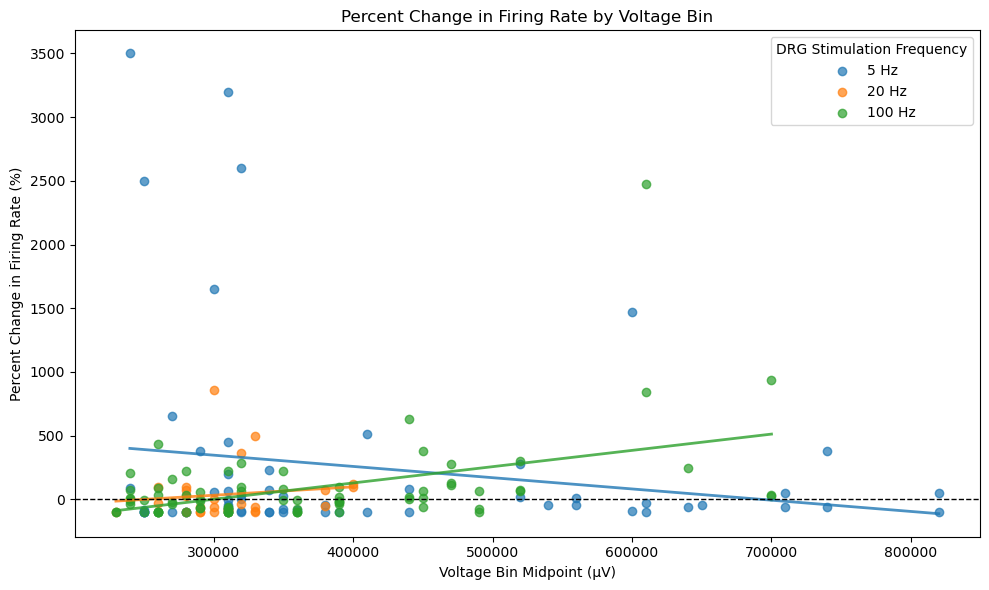

In [48]:
plot_percent_change(pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW327"])

### DW322

In [49]:
pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW322"].sort_values(["percent_change"], ascending=False)

group,Rat_ID,Trial_ID,cluster,voltage_bin,Frequency_Hz,post-stim,pre-stim,percent_change
38,DW322,DW322_VF_1_240918_143256,38.0,910000,5,70.0,2.000000,3400.000000
624,DW322,DW322_VF_8_240918_152056,25.0,620000,100,20.0,1.000000,1900.000000
341,DW322,DW322_VF_6_240918_150811,2.0,250000,20,24.0,2.000000,1100.000000
564,DW322,DW322_VF_7_240918_151516,28.0,510000,5,90.0,8.000000,1025.000000
712,DW322,DW322_VF_9_240918_152753,12.0,670000,20,20.0,2.294455,771.666667
...,...,...,...,...,...,...,...,...
586,DW322,DW322_VF_8_240918_152056,25.0,450000,100,0.0,44.000000,-100.000000
292,DW322,DW322_VF_5_240918_150137,30.0,490000,5,0.0,2.000000,-100.000000
307,DW322,DW322_VF_5_240918_150137,30.0,900000,5,0.0,38.000000,-100.000000
548,DW322,DW322_VF_7_240918_151516,28.0,490000,5,0.0,26.000000,-100.000000


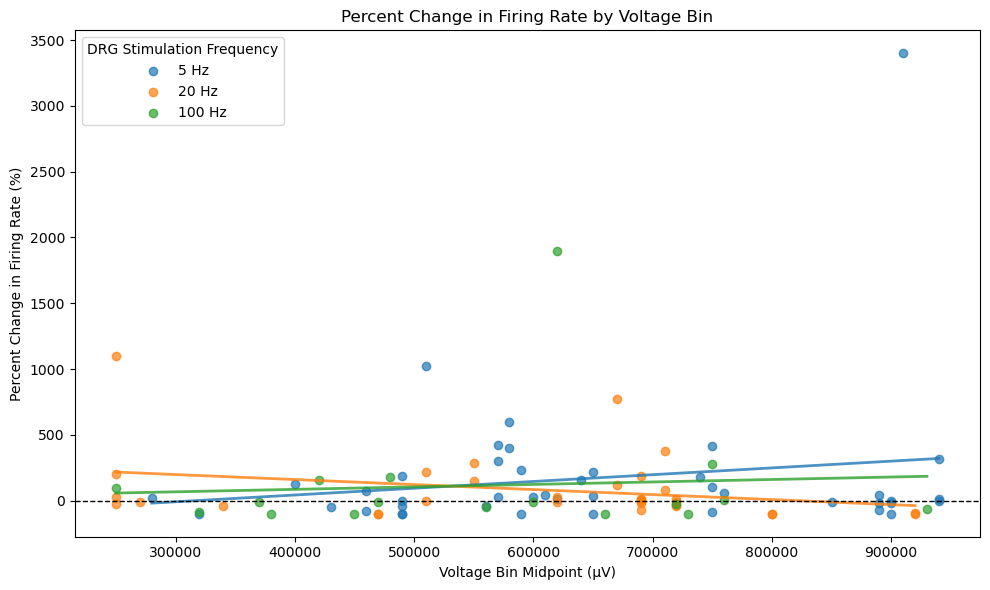

In [50]:
plot_percent_change(pre_post_pivot[pre_post_pivot["Rat_ID"]=="DW322"])

# 📈 linear mixed effects model - nested cluster, trial, rat id
---

Combine the Results and Metadata:
You would need to create (or extract) a DataFrame where each row corresponds to a sub-window (or trial) with columns for the dependent variable (for example, average voltage), the fixed effects (e.g. stimulation, pulse width, waiting), and a column indicating the animal (rat ID). You might need to merge your VonFreyAnalysis results with metadata that specifies stimulation parameters.

Fit a Mixed Effects Model:
Use the statsmodels MixedLM or the formula interface (statsmodels.formula.api.mixedlm) to specify a model with fixed effects for voltage, stimulation, pulse width, waiting and a random intercept for animal.


MAKE SURE TO DO THIS STEP


when you filter by correlation threshhold, it is going to drop rows and some of the data may refer to old indices.  This can happen if you drop rows (for example, due to missing percent_change values) without resetting the index, so some groups still reference old index values.



this graph is hard to draw any conclusions from - plot the average trend, with std error bars

    #### structure of dataset

    * Rat
        * trial 
            * cluster ID

    #### Predictor/Fixed Variable:
    * Frequency_Hz (categorical: 5, 20, 100 Hz): frequency of DRG stimulation
    #### Random Effects:
    * Rat_ID: Differences in baseline firing changes between animals.
    * Trial_ID (nested within Rat_ID): Trial‐to‐trial variability (per animal).
    * Trial_Cluster: Variability at the neuron level (per trial).

**Model Formula:**

$$
\text{percent\_change\_firing} \sim \text{Frequency\_Hz} + (1 \mid \text{Rat\_ID}) + \{ \text{Trial}: 0 + C(\text{Trial\_ID}),\ \text{Neuron}: 0 + C(\text{Cluster}) \}
$$

#### methods

In [51]:

# Convert variables to categorical types
pre_post_pivot['Rat_ID']   = pre_post_pivot['Rat_ID'].astype('category')
pre_post_pivot['Trial_ID'] = pre_post_pivot['Trial_ID'].astype('category')
pre_post_pivot['cluster']  = pre_post_pivot['cluster'].astype('category')
pre_post_pivot["percent_change"] = pre_post_pivot["percent_change"].astype('float')


# Define variance components for trial and neuron (cluster)
vc = {
    'Trial': '0 + C(Trial_ID)',
    'Neuron': '0 + C(cluster)',
}

# Specify the mixed effects model
model = smf.mixedlm("percent_change ~ Frequency_Hz + voltage_bin", pre_post_pivot, groups=pre_post_pivot["Rat_ID"], vc_formula=vc)
result = model.fit()

# Display the model summary
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: percent_change
No. Observations: 939     Method:             REML          
No. Groups:       4       Scale:              81469.3780    
Min. group size:  34      Log-Likelihood:     -6705.0918    
Max. group size:  646     Converged:          Yes           
Mean group size:  234.8                                     
------------------------------------------------------------
                Coef.   Std.Err.   z    P>|z| [0.025  0.975]
------------------------------------------------------------
Intercept       142.594   48.958  2.913 0.004 46.637 238.551
Frequency_Hz     -0.888    0.647 -1.372 0.170 -2.156   0.380
voltage_bin      -0.000    0.000 -1.502 0.133 -0.000   0.000
Neuron Var    13544.287   17.604                            
Trial Var     13779.601   23.441                            



things that could be possible:

1. Multicollinearity - are Frequency and Voltage correlated?
2. Trial_ID cluster have only than one level per group.
3. Trial_ID cluster levels are not overly sparse or redundant with the fixed effects.

In [52]:
pre_post_pivot['Frequency_Hz'].describe()


count    939.000000
mean      33.024494
std       39.225721
min        5.000000
25%        5.000000
50%       20.000000
75%       60.000000
max      100.000000
Name: Frequency_Hz, dtype: float64

In [53]:
pre_post_pivot['voltage_bin'].describe()

count    9.390000e+02
mean     5.966347e+05
std      2.111234e+05
min      2.300000e+05
25%      4.400000e+05
50%      6.000000e+05
75%      7.200000e+05
max      1.150000e+06
Name: voltage_bin, dtype: float64

In [54]:
pre_post_pivot[['Frequency_Hz', 'voltage_bin']].corr()

group,Frequency_Hz,voltage_bin
group,,
Frequency_Hz,1.000000,-0.172752
voltage_bin,-0.172752,1.000000


ok, so these values are not highly correlated. this tells me we don't have enough data then?

In [55]:

# Convert variables to categorical types
pre_post_pivot['Rat_ID']   = pre_post_pivot['Rat_ID'].astype('category')
pre_post_pivot['Trial_ID'] = pre_post_pivot['Trial_ID'].astype('category')
pre_post_pivot['cluster']  = pre_post_pivot['cluster'].astype('category')
pre_post_pivot["percent_change"] = pre_post_pivot["percent_change"].astype('float')


# Define variance components for trial and neuron (cluster)
vc = {
    'Trial': '0 + C(Trial_ID)',
    'Neuron': '0 + C(Trial_ID):C(cluster)'  # neurons nested within trials
}

# Specify the mixed effects model
model = smf.mixedlm("percent_change ~ Frequency_Hz", pre_post_pivot, groups=pre_post_pivot["Rat_ID"], vc_formula=vc)
result = model.fit()

# Display the model summary
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: percent_change
No. Observations: 939     Method:             REML          
No. Groups:       4       Scale:              81813.9198    
Min. group size:  34      Log-Likelihood:     -6699.1083    
Max. group size:  646     Converged:          Yes           
Mean group size:  234.8                                     
------------------------------------------------------------
                Coef.   Std.Err.   z    P>|z| [0.025  0.975]
------------------------------------------------------------
Intercept        98.103   37.956  2.585 0.010 23.711 172.495
Frequency_Hz     -0.938    0.671 -1.398 0.162 -2.253   0.377
Neuron Var    10532.440   14.536                            
Trial Var     15854.987   24.211                            



In [56]:

# Convert variables to categorical types
pre_post_pivot['Rat_ID']   = pre_post_pivot['Rat_ID'].astype('category')
pre_post_pivot['Trial_ID'] = pre_post_pivot['Trial_ID'].astype('category')
pre_post_pivot['cluster']  = pre_post_pivot['cluster'].astype('category')
pre_post_pivot["percent_change"] = pre_post_pivot["percent_change"].astype('float')


# Define variance components for trial and neuron (cluster)
vc = {
    'Neuron': 'C(cluster)'  # neurons nested within trials
}

# Specify the mixed effects model
model = smf.mixedlm("percent_change ~ Frequency_Hz", pre_post_pivot, groups=pre_post_pivot["Trial_ID"], vc_formula=vc)
result = model.fit()

# Display the model summary
print(result.summary())

c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karl\.conda\envs\kilosort\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: percent_change
No. Observations: 939     Method:             REML          
No. Groups:       32      Scale:              81065.1534    
Min. group size:  4       Log-Likelihood:     -6699.3899    
Max. group size:  135     Converged:          Yes           
Mean group size:  29.3                                      
------------------------------------------------------------
                Coef.   Std.Err.   z    P>|z| [0.025  0.975]
------------------------------------------------------------
Intercept        94.034   35.734  2.632 0.009 23.997 164.071
Frequency_Hz     -0.871    0.640 -1.361 0.173 -2.125   0.383
Neuron Var    13214.301   12.478                            

